In [2]:
!pip install segmentation_models

In [0]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras import optimizers
from sklearn.model_selection import train_test_split
import segmentation_models as sm
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.io import imsave
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
from itertools import cycle

In [3]:
#Download the dataset
!wget https://zenodo.org/record/3757476/files/COVID-19-CT-Seg_20cases.zip?download=1
!wget https://zenodo.org/record/3757476/files/Lung_and_Infection_Mask.zip?download=1

--2020-06-04 07:45:42--  https://zenodo.org/record/3757476/files/COVID-19-CT-Seg_20cases.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.184.117.155
Connecting to zenodo.org (zenodo.org)|188.184.117.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1105395143 (1.0G) [application/octet-stream]
Saving to: ‘COVID-19-CT-Seg_20cases.zip?download=1’

COVID-19-CT-Seg_20c 100%[===================>]   1.03G  24.5MB/s    in 68s     

2020-06-04 07:48:51 (15.6 MB/s) - ‘COVID-19-CT-Seg_20cases.zip?download=1’ saved [1105395143/1105395143]

--2020-06-04 07:48:53--  https://zenodo.org/record/3757476/files/Lung_and_Infection_Mask.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.184.117.155
Connecting to zenodo.org (zenodo.org)|188.184.117.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11714838 (11M) [application/octet-stream]
Saving to: ‘Lung_and_Infection_Mask.zip?download=1’

Lung_and_Infection_ 100%[===================>]  11

In [0]:
#Rename zip file
!mv COVID-19-CT-Seg_20cases.zip?download=1 COVID-19-CT-Seg_20cases.zip
!mv Lung_and_Infection_Mask.zip?download=1 Lung_and_Infection_Mask.zip

In [5]:
#extract data 
!mkdir images && unzip COVID-19-CT-Seg_20cases.zip -d images
!mkdir masks && unzip Lung_and_Infection_Mask.zip -d masks
!mkdir training_data
!rm images/ReadMe.txt


Archive:  COVID-19-CT-Seg_20cases.zip
  inflating: images/coronacases_001.nii.gz  
  inflating: images/coronacases_002.nii.gz  
  inflating: images/coronacases_003.nii.gz  
  inflating: images/coronacases_004.nii.gz  
  inflating: images/coronacases_005.nii.gz  
  inflating: images/coronacases_006.nii.gz  
  inflating: images/coronacases_007.nii.gz  
  inflating: images/coronacases_008.nii.gz  
  inflating: images/coronacases_009.nii.gz  
  inflating: images/coronacases_010.nii.gz  
  inflating: images/radiopaedia_10_85902_1.nii.gz  
  inflating: images/radiopaedia_10_85902_3.nii.gz  
  inflating: images/radiopaedia_14_85914_0.nii.gz  
  inflating: images/radiopaedia_27_86410_0.nii.gz  
  inflating: images/radiopaedia_29_86490_1.nii.gz  
  inflating: images/radiopaedia_29_86491_1.nii.gz  
  inflating: images/radiopaedia_36_86526_0.nii.gz  
  inflating: images/radiopaedia_40_86625_0.nii.gz  
  inflating: images/radiopaedia_4_85506_1.nii.gz  
  inflating: images/radiopaedia_7_85703_0.nii

In [0]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
IMG_CHANNELS = 1
def imgNorm(img):
  div = np.max(img) - np.min(img)

  return 255*(img - np.min(img))/div


def oneHotMask(mask, cataNum=4):
  shape = mask.shape
  shape = list(shape)
  shape.append(cataNum)
  result = np.zeros(shape)
  # print(np.max(mask))
  for i in range(cataNum):
    temp = np.zeros(mask.shape)
    temp[mask==i] = 1
    result[:,:,i] = temp
  return result

def pre_processing(imgPath, gtPath, opPath, normalize=True, oneHot=True, newSize=[IMG_WIDTH,IMG_HEIGHT], cataNum=4):
  """
  the ouput png file will be store in folder 'img' and 'label' under given opPath

  @param imgPath: folder containing the input nifti file
  @param gtPath: folder contatining the groud truth nifti file
  @param opPath: output folder
  @param normalize: normalize the input or not
  @param oneHot: convert the mask to one hot image or not
  @param newSize: the size of the ouput img/label
  @param cataNum: number of catagories for mask

  example:
  imgPath = './COVID-19-CT-Seg_20cases/'
  gtPath = './Lung_and_Infection_Mask/'
  savePath = './processed/'
  pre_processing(imgPath, gtPath, savePath)

  """
  imgFile = imgPath
  gtFile = gtPath
  savePath = opPath

  gtList = os.listdir(gtFile)

  opImgPath = os.path.join(savePath,'img/')
  opGtPath = os.path.join(savePath,'label/')


  if not os.path.isdir(savePath):
    os.mkdir(savePath)
  if not os.path.isdir(opImgPath):
    os.mkdir(opImgPath)
  if not os.path.isdir(opGtPath):
    os.mkdir(opGtPath)

  studyNum = len(gtList)

  for i in range(studyNum):
    gt = nib.load(gtFile + gtList[i]).get_fdata()
    img = nib.load(imgFile + gtList[i]).get_fdata()

    slices = img.shape[2]
    for s in range(slices):
      if oneHot:
        gtTemp = oneHotMask(gt[:,:,s], cataNum=cataNum)
      else:
        gtTemp = gt[:,:,s]
      gtTemp = resize(gtTemp, newSize, preserve_range=True)
      gtTemp = gtTemp.astype(np.uint8)
      imgTemp = resize(img[:,:,s], newSize, preserve_range=True)
      imgTemp = imgNorm(imgTemp)
      imgTemp = imgTemp.astype(np.uint8)
      gtName = 'case_' + str(i) + '_slices_' + str(s) + '.png'
      imgName = 'case_' + str(i) + '_slices_' + str(s) + '.png'
      imsave(opImgPath+imgName, imgTemp, check_contrast=False)
      imsave(opGtPath+gtName, gtTemp, check_contrast=False)

  return

In [7]:
#load data
images_filepath = sorted(os.listdir('images'))
masks_filepath = sorted(os.listdir('masks'))
print(images_filepath)
print(images_filepath)

current_path = os.getcwd()
images_folder_path = os.path.join(current_path,"images/")
masks_folder_path = os.path.join(current_path,"masks/")
training_data_path = os.path.join(current_path,"training_data/")
print(images_folder_path)
print(masks_folder_path)
# train_list = np.empty((0,512, 512, 1), dtype=np.uint8)
# sum = 0
# for image_filepath, mask_filepath in zip(images_filepath, masks_filepath):
  # if sum == 2:
  #   break
  # image_file = os.path.join(images_folder_path, image_filepath) 
  # image = nib.load(image_file)
  # image_data = image.get_fdata()
  # image_data = np.asarray(image_data,dtype=np.uint8)
  # image_data = np.swapaxes(image_data,0,2)
  # image_data_tmp = resize(image_data[])
  # image_data = np.expand_dims(image_data,axis=-1)
  # sum += image_data.shape[2]
  # print(image_data.shape)

  # mask_file = os.path.join(masks_folder_path, mask_filepath)
  # mask = nib.load(mask_file)
  # mask_data = mask.get_fdata()
  # print(mask_data.shape)

  # train_list = np.concatenate((train_list,image_data))
# print(train_list.shape)
# print(sum)

# pre_processing(images_folder_path,masks_folder_path,training_data_path)

['coronacases_001.nii.gz', 'coronacases_002.nii.gz', 'coronacases_003.nii.gz', 'coronacases_004.nii.gz', 'coronacases_005.nii.gz', 'coronacases_006.nii.gz', 'coronacases_007.nii.gz', 'coronacases_008.nii.gz', 'coronacases_009.nii.gz', 'coronacases_010.nii.gz', 'radiopaedia_10_85902_1.nii.gz', 'radiopaedia_10_85902_3.nii.gz', 'radiopaedia_14_85914_0.nii.gz', 'radiopaedia_27_86410_0.nii.gz', 'radiopaedia_29_86490_1.nii.gz', 'radiopaedia_29_86491_1.nii.gz', 'radiopaedia_36_86526_0.nii.gz', 'radiopaedia_40_86625_0.nii.gz', 'radiopaedia_4_85506_1.nii.gz', 'radiopaedia_7_85703_0.nii.gz']
['coronacases_001.nii.gz', 'coronacases_002.nii.gz', 'coronacases_003.nii.gz', 'coronacases_004.nii.gz', 'coronacases_005.nii.gz', 'coronacases_006.nii.gz', 'coronacases_007.nii.gz', 'coronacases_008.nii.gz', 'coronacases_009.nii.gz', 'coronacases_010.nii.gz', 'radiopaedia_10_85902_1.nii.gz', 'radiopaedia_10_85902_3.nii.gz', 'radiopaedia_14_85914_0.nii.gz', 'radiopaedia_27_86410_0.nii.gz', 'radiopaedia_29_86

In [0]:
pre_processing(images_folder_path,masks_folder_path,training_data_path)

In [8]:
images_filepath = sorted(os.listdir(training_data_path + '/img'))
masks_filepath = sorted(os.listdir(training_data_path + '/label'))

print(images_filepath)
print(masks_filepath)
print(len(images_filepath))

['case_0_slices_0.png', 'case_0_slices_1.png', 'case_0_slices_10.png', 'case_0_slices_100.png', 'case_0_slices_101.png', 'case_0_slices_102.png', 'case_0_slices_103.png', 'case_0_slices_104.png', 'case_0_slices_105.png', 'case_0_slices_106.png', 'case_0_slices_107.png', 'case_0_slices_108.png', 'case_0_slices_109.png', 'case_0_slices_11.png', 'case_0_slices_110.png', 'case_0_slices_111.png', 'case_0_slices_112.png', 'case_0_slices_113.png', 'case_0_slices_114.png', 'case_0_slices_115.png', 'case_0_slices_116.png', 'case_0_slices_117.png', 'case_0_slices_118.png', 'case_0_slices_119.png', 'case_0_slices_12.png', 'case_0_slices_120.png', 'case_0_slices_121.png', 'case_0_slices_122.png', 'case_0_slices_123.png', 'case_0_slices_124.png', 'case_0_slices_125.png', 'case_0_slices_126.png', 'case_0_slices_127.png', 'case_0_slices_128.png', 'case_0_slices_129.png', 'case_0_slices_13.png', 'case_0_slices_130.png', 'case_0_slices_131.png', 'case_0_slices_132.png', 'case_0_slices_133.png', 'case_0

In [0]:
# images_filepath = sorted(os.listdir(training_data_path + '/img'))
# masks_filepath = sorted(os.listdir(training_data_path + '/label'))

# train_list = []
# mask_list = []
# count1 = 0
# count2 = 0
X_train = np.zeros((3520, IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.uint8)
Y_train = np.zeros((3520, IMG_HEIGHT, IMG_WIDTH, 4), dtype=np.uint8)
i = 0

for img, mask in zip(images_filepath, masks_filepath):
  train = imread(training_data_path + "img/" + img)
  train = np.expand_dims(train, axis=-1)
  X_train[i] = train

  mas = imread(training_data_path + "label/" + mask)
  Y_train[i] = mas
  i+=1
  # print(training_data_path + "img/" + i)
  # print(mask_list[0].shape)

# print(count1)
# print(count2)
# print(nask_list[0].shape)
# X_train = np.zeros((3520, IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.uint8)
# Y_train = np.zeros((3520, IMG_HEIGHT, IMG_WIDTH, 4), dtype=np.uint8)
# print(X_train.shape)
# print(Y_train.shape)
# for img, msk in zip(train_list, mask_list):
#     img = np.expand_dims(img, axis=-1)
#     X_train[i] = img

#     # mask = np.expand_dims(msk,axis=-1)
#     # t1 = 0
#     # m = m/255
#     # mask[mask > t1] = 1
#     # mask[mask <= t1] = 0
#     Y_train[i] = msk

#     i += 1


In [0]:
#split train, val, test dataset
seed = 42
random.seed = seed
np.random.seed = seed
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=42)

In [11]:
ix = 10
print(np.sum(y_train[ix], axis=-1))

[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


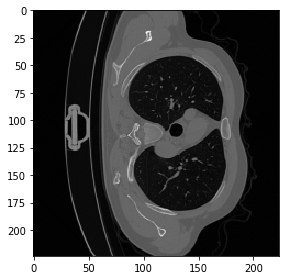

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


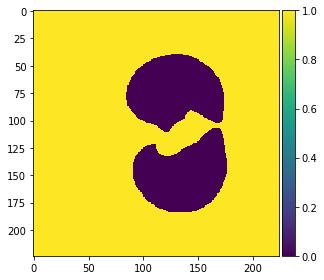

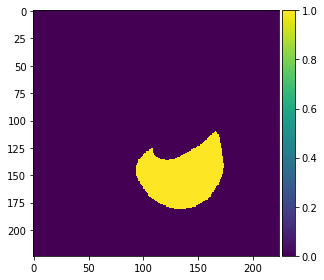

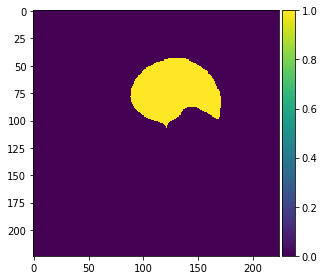

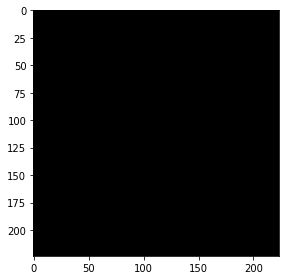

(224, 224, 1)

In [12]:
ix = 30
imshow(x_train[ix,:,:,0])
plt.show()
imshow(np.squeeze(y_train[ix,:,:,0]))
plt.show()
imshow(np.squeeze(y_train[ix,:,:,1]))
plt.show()
imshow(np.squeeze(y_train[ix,:,:,2]))
plt.show()
imshow(np.squeeze(y_train[ix,:,:,3]))
plt.show()
X_train[ix].shape

In [0]:
#IOU metrics
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [0]:
def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score
 
def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
 
#ComboLoss
 
def Tversky_Loss(y_true, y_pred, smooth = 1, alpha = 0.3, beta = 0.7, flatten = False):
    
    if flatten:
        y_true = K.flatten(y_true)
        y_pred = K.flatten(y_pred)
    
    TP = K.sum(y_true * y_pred)
    FP = K.sum((1-y_true) * y_pred)
    FN = K.sum(y_true * (1-y_pred))
    
    tversky_coef = (TP + smooth) / (TP + alpha * FP + beta * FN + smooth)
    
    return 1 - tversky_coef
 
def Focal_Loss(y_true, y_pred, alpha = 0.8, gamma = 2.0, flatten = False):
    
    if flatten:
        y_true = K.flatten(y_true)
        y_pred = K.flatten(y_pred)    
    
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    bce_exp = K.exp(-bce)
    
    loss = K.mean(alpha * K.pow((1-bce_exp), gamma) * bce)
    return loss
 
def weighted_bce(weight = 0.6):
    
    def convert_2_logits(y_pred):
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1 - K.epsilon())
        return tf.math.log(y_pred / (1-y_pred))
    
    def weighted_binary_crossentropy(y_true, y_pred):
        y_pred = convert_2_logits(y_pred)
        loss = tf.nn.weighted_cross_entropy_with_logits(logits = y_pred, labels = y_true, pos_weight = weight)
        return loss
    
    return weighted_binary_crossentropy
 
def Combo_Loss(y_true, y_pred, a = 0.4, b = 0.2, c= 0.4):
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    return a*weighted_bce()(y_true, y_pred) + b*Focal_Loss(y_true_f, y_pred_f) + c*Tversky_Loss(y_true_f, y_pred_f)
 
def Dice_coef(y_true, y_pred, smooth = 1):
 
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
 
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
 
def Dice_loss(y_true, y_pred):   
    return  1.0 - Dice_coef(y_true, y_pred)
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [38]:
BACKBONE = 'efficientnetb7'
opt = optimizers.Adam(lr=1E-4)

model = sm.Unet(BACKBONE, classes = 4,input_shape=(IMG_WIDTH, IMG_HEIGHT, 1), encoder_weights=None)
model.compile(optimizer=opt, loss= Combo_Loss, metrics= [dice_coef])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 1)  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 64) 576         input_2[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 64) 256         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 64) 0           stem_bn[0][0]                    
____________________________________________________________________________________________

In [43]:
# Build U-Net model
num_filters = 16
inputs = Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)
c1 = Conv2D(num_filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (s)
# b11 = BatchNormalization(axis=3)(c1)
c1 = Conv2D(num_filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
# b12 = BatchNormalization(axis=3)(c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(num_filters*2, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
# b21 = BatchNormalization(axis=3)(c2)
# c2 = Dropout(0.1) (c2)
c2 = Conv2D(num_filters*2, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
# b22 = BatchNormalization(axis=3)(c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(num_filters*4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
# b3 = BatchNormalization(axis=3)(c3)
# c3 = Dropout(0.2) (c3)
c3 = Conv2D(num_filters*4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(num_filters*8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
# b4 = BatchNormalization(axis=3)(c4)
c4 = Conv2D(num_filters*8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
# d4 = Dropout(0.5) (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(num_filters*16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
# b5 = BatchNormalization(axis=3)(c5)
c5 = Conv2D(num_filters*16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)
# d5 = Dropout(0.5) (c5)

u6 = Conv2DTranspose(num_filters*8, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(num_filters*8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u6)
# b6 = BatchNormalization(axis=3)(c6)
c6 = Conv2D(num_filters*8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(num_filters*4, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(num_filters*4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
# b7 = BatchNormalization(axis=3)(c7)
c7 = Conv2D(num_filters*4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(num_filters*2, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(num_filters*2, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
# b8 = BatchNormalization(axis=3)(c8)
c8 = Conv2D(num_filters*2, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(num_filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
# b9 = BatchNormalization(axis=3)(c9)
c9 = Conv2D(num_filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)
# c9 = Conv2D(4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(4, (1, 1), activation='softmax') (c9)
opt = optimizers.Adam(lr=1E-4)

model = Model(inputs=[inputs], outputs=[outputs])
# model.compile(optimizer=opt, loss= Combo_Loss, metrics= [dice_coef])
model.compile(optimizer=opt, loss= 'categorical_crossentropy', metrics= ['accuracy'])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 1)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 224, 224, 1)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 16) 160         lambda_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 224, 224, 16) 2320        conv2d_1[0][0]                   
____________________________________________________________________________________________

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [44]:
# #training function
# # checkpointer = ModelCheckpoint('unet_model_.h5', verbose=1, save_best_only=True)
# # results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=8, epochs=60)
# from datetime import datetime

# date_str = datetime.today().strftime('%Y-%m-%d-%H:%M')
# # print(date_str)
# !mkdir /content/drive/My\ Drive/ssi_project/$date_str
# save_path = "/content/drive/My Drive/ssi_project/" + date_str
# # print(save_path)
# file_path = save_path + "/weights.hdf5"
# checkpointer = ModelCheckpoint(file_path, verbose=1, save_best_only=True, mode='max')
# early_stop = tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss')
# results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=32, epochs=30, callbacks=[checkpointer,early_stop])
early_stop = tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss')

results = model.fit(x_train, y_train, batch_size=32, epochs=60,validation_data=(x_val,y_val),verbose = 1, callbacks=[early_stop])

Train on 2112 samples, validate on 704 samples
Epoch 1/60
2112/2112 [==============================] - 36s 17ms/step - loss: 0.8383 - accuracy: 0.6129 - val_loss: 0.3150 - val_accuracy: 0.9169
Epoch 2/60
2112/2112 [==============================] - 32s 15ms/step - loss: 0.2079 - accuracy: 0.9230 - val_loss: 0.1543 - val_accuracy: 0.9256
Epoch 3/60
2112/2112 [==============================] - 32s 15ms/step - loss: 0.1406 - accuracy: 0.9262 - val_loss: 0.1249 - val_accuracy: 0.9307
Epoch 4/60
2112/2112 [==============================] - 32s 15ms/step - loss: 0.1176 - accuracy: 0.9360 - val_loss: 0.1044 - val_accuracy: 0.9405
Epoch 5/60
2112/2112 [==============================] - 32s 15ms/step - loss: 0.0937 - accuracy: 0.9397 - val_loss: 0.0848 - val_accuracy: 0.9373
Epoch 6/60
2112/2112 [==============================] - 32s 15ms/step - loss: 0.0798 - accuracy: 0.9418 - val_loss: 0.0753 - val_accuracy: 0.9408
Epoch 7/60
2112/2112 [==============================] - 32s 15ms/step - loss:

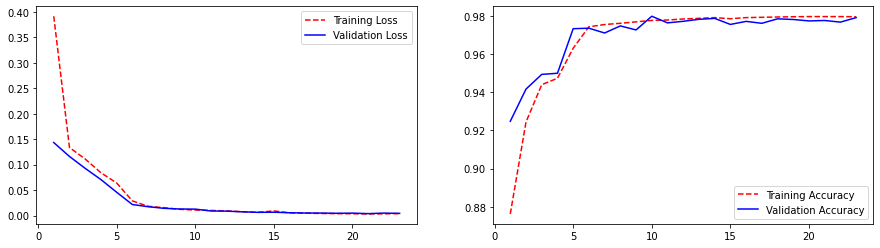

In [0]:
#plot the training progress
fig, axs = plt.subplots(1, 2, figsize = (15, 4))

training_loss = results.history['loss']
validation_loss = results.history['val_loss']

training_accuracy = results.history['accuracy']
validation_accuracy = results.history['val_accuracy']

epoch_count = range(1, len(training_loss) + 1)

axs[0].plot(epoch_count, training_loss, 'r--')
axs[0].plot(epoch_count, validation_loss, 'b-')
axs[0].legend(['Training Loss', 'Validation Loss'])

axs[1].plot(epoch_count, training_accuracy, 'r--')
axs[1].plot(epoch_count, validation_accuracy, 'b-')
axs[1].legend(['Training Accuracy', 'Validation Accuracy'])

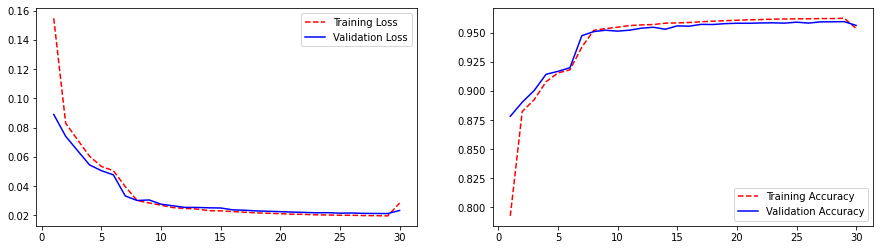

In [0]:
#plot the training progress
fig, axs = plt.subplots(1, 2, figsize = (15, 4))

training_loss = results.history['loss']
validation_loss = results.history['val_loss']

training_accuracy = results.history['dice_coef']
validation_accuracy = results.history['val_dice_coef']

epoch_count = range(1, len(training_loss) + 1)

axs[0].plot(epoch_count, training_loss, 'r--')
axs[0].plot(epoch_count, validation_loss, 'b-')
axs[0].legend(['Training Loss', 'Validation Loss'])

axs[1].plot(epoch_count, training_accuracy, 'r--')
axs[1].plot(epoch_count, validation_accuracy, 'b-')
axs[1].legend(['Training Accuracy', 'Validation Accuracy'])

In [0]:
filepath = "/content/drive/My Drive/ssi_project/trained_model/"
model.save(filepath + "dice_loss.h5")

In [14]:
# import keras.losses
# keras.losses.Combo_Loss = Combo_Loss

filepath = "/content/drive/My Drive/ssi_project/trained_model/original_unet/"
model = tf.keras.models.load_model(filepath + 'crossentropy.h5')
# model = load_model(filepath + 'dice_loss.h5', custom_objects={'Combo_Loss': Combo_Loss,'dice_coef':dice_coef})
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 256, 256, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 160         lambda_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 16) 64          conv2d_1[0][0]                   
____________________________________________________________________________________________

In [40]:
# Evaluate the model on the test data using `evaluate`
print('\n# Evaluate on test data')
results = model.evaluate(x_test, y_test, batch_size=16)
print('test loss, test acc:', results)
# print(model.metrics_names)


# Evaluate on test data
704/704 [==============================] - 34s 48ms/step
test loss, test acc: [0.018498918613080274, 0.9800707101821899]


In [0]:
#draw ROC curve 
def draw_roc_curve(gt,pred,multi=False,num_class = 4):
    """
    Draw ROC curve for each class
    
    @param gt: ground truth mask(s) of shape [num_masks, image_width, image_height, num_classes]
    @param pred: prediction mask(s) of shape [num_masks, image_width, image_height, num_classes]
    @param multi: False to draw roc curve for 1 image. True to draw for multi images
    @param num_class: number of classes

    example:
    preds = model.predict(x_test,verbose = 1)
    gts = y_test
    draw_roc_curve(gts,preds,multi=True)
    """

    
    if multi:
        if gt.ndim != 4 or pred.ndim != 4:
            print("Dimension of gt and pred must be 4 for drawing multi images curve!")
            return

        num_test_samples = pred.shape[0]
        gt_sep = np.zeros((num_test_samples,IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)
        pred_sep = np.zeros((num_test_samples,IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)
    
    else:
        if gt.ndim != 3 or pred.ndim != 4:
            print("Dimension of gt must be 3 and pred must be 4 for drawing single image curve!")
            return

        # gt = np.argmax(gt,axis=-1)
        gt_sep = np.zeros((IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)
        pred_sep = np.zeros((IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)
    
    gt = np.argmax(gt,axis=-1)
    pred = np.argmax(pred,axis=-1)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()


    for i in range(num_class):
        if i == 0:
            gt_sep = np.where(gt == i, 0, 1)
            pred_sep = np.where(pred == i, 0, 1)
        else:
            gt_sep = np.where(gt == i, 1, 0)
            pred_sep = np.where(pred == i, 1, 0)

        fpr[i], tpr[i], _ = roc_curve(gt_sep.flatten(), pred_sep.flatten())
        roc_auc[i] = auc(fpr[i],tpr[i])

    lw = 2
    plt.figure()
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue','green'])
    classes = ['Background','Left Lung','Right Lung','Infection']
    for i, color in zip(range(num_class), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                label='ROC curve of class {0} (area = {1:0.2f})'
                ''.format(classes[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()  


In [0]:
def draw_all_roc_curve(gt,pred):
  
    num_class = 4
    num_test_samples = pred.shape[0]
    gt_sep = np.zeros((num_test_samples,IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)
    pred_sep = np.zeros((num_test_samples,IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()


    for i in range(num_class):
        if i == 0:
            gt_sep = np.where(gt == i, 0, 1)
            pred_sep = np.where(pred == i, 0, 1)
        else:
            gt_sep = np.where(gt == i, 1, 0)
            pred_sep = np.where(pred == i, 1, 0)
    # gt_sep = np.where(gt == i, 1, 0)
    # pred_sep = np.where(pred == i, 1, 0)
        fpr[i], tpr[i], _ = roc_curve(gt_sep.flatten(), pred_sep.flatten())
        roc_auc[i] = auc(fpr[i],tpr[i])
        print(dc(pred_sep.flatten(),gt_sep.flatten()))
        # bland_altman_plot(pred_sep.flatten(),gt_sep.flatten())
    lw = 2
    plt.figure()
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue','green'])
    classes = ['Background','Left Lung','Right Lung','Infection']

    for i, color in zip(range(num_class), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                label='{0} (area = {1:0.2f})'
                ''.format(classes[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()    

Img shape:  (224, 224, 1)
New img shape:  (1, 224, 224, 1)
GT shape:  (224, 224, 4)
1/1 [==============================] - 0s 930us/step
Predict shape:  (1, 224, 224, 4)
New Predict shape:  (224, 224)
[0 1 2 3]
New GT shape:  (224, 224)
[0 1 2 3]


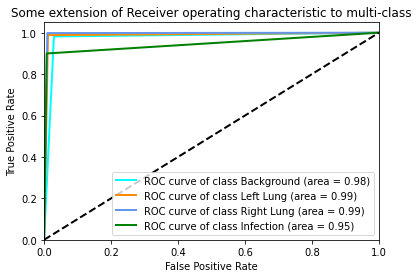

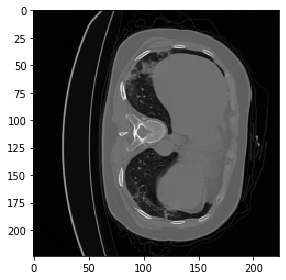

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


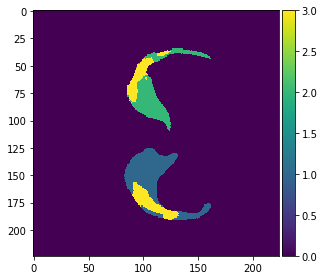

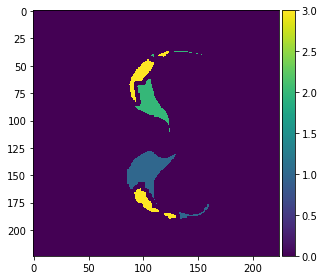

In [61]:
ix = 6
img = x_test[ix]
print("Img shape: ",img.shape)
img = np.expand_dims(img,axis=-1)
img = np.swapaxes(img,2,3)
img = np.swapaxes(img,1,2)
img = np.swapaxes(img,0,1)
print("New img shape: ",img.shape)
gt = y_test[ix]
print("GT shape: ",gt.shape)


preds_train = model.predict(img, verbose=1)
print("Predict shape: ",preds_train.shape)

max_val = np.argmax(preds_train[0,:,:,:], axis=-1)


print("New Predict shape: ",max_val.shape)
print(np.unique(max_val))


combined_gt = np.argmax(gt, axis=-1)
print("New GT shape: ",combined_gt.shape)
print(np.unique(combined_gt))

draw_roc_curve(gt, preds_train)

imshow(np.squeeze(img[0,:,:,0]))
plt.show()
# imshow(np.squeeze(preds_train[0,:,:,0]))
# plt.show()
# imshow(np.squeeze(preds_train[0,:,:,1]))
# plt.show()
# imshow(np.squeeze(preds_train[0,:,:,2]))
# plt.show()
# imshow(np.squeeze(preds_train[0,:,:,3]))
# plt.show()
imshow(max_val)
plt.show()
imshow(combined_gt)
plt.show()

# if img.ndim != 4 or preds_train.ndim != 4: 
#     print("blobla")
# print(img.ndim)

In [64]:
imgs = x_test
print("Imgs shape:",imgs.shape)

preds = model.predict(imgs, verbose = 1)
print("Preds shape: ",preds.shape)

max_vals = np.argmax(preds, axis=-1)
print("New Predict shape: ",max_vals.shape)
print(np.unique(max_vals))



Imgs shape: (704, 224, 224, 1)
22/22 [==============================] - 3s 136ms/step
Preds shape:  (704, 224, 224, 4)
New Predict shape:  (704, 224, 224)
[0 1 2 3]


In [65]:
gts = y_test
print(gts.shape)
max_gts = np.argmax(gts, axis=-1)
print("New GT shape: ",max_gts.shape)
print(np.unique(max_gts))



(704, 224, 224, 4)
New GT shape:  (704, 224, 224)
[0 1 2 3]


In [63]:
draw_all_roc_curve(max_gts, max_vals)

Dimension of gt and pred must be 4 for drawing multi images curve!


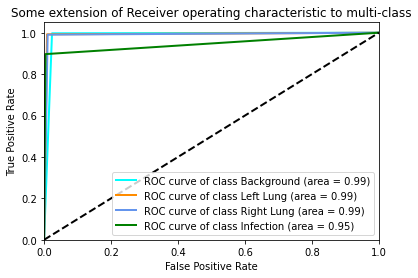

In [66]:
draw_roc_curve(gts,preds,multi=True)

In [0]:
def dc(result, reference):
    r"""
    Dice coefficient
    
    Computes the Dice coefficient (also known as Sorensen index) between the binary
    objects in two images.
    
    The metric is defined as
    
    .. math::
        
        DC=\frac{2|A\cap B|}{|A|+|B|}
        
    , where :math:`A` is the first and :math:`B` the second set of samples (here: binary objects).
    
    Parameters
    ----------
    result : array_like
        Input data containing objects. Can be any type but will be converted
        into binary: background where 0, object everywhere else.
    reference : array_like
        Input data containing objects. Can be any type but will be converted
        into binary: background where 0, object everywhere else.
    
    Returns
    -------
    dc : float
        The Dice coefficient between the object(s) in ```result``` and the
        object(s) in ```reference```. It ranges from 0 (no overlap) to 1 (perfect overlap).
        
    Notes
    -----
    This is a real metric. The binary images can therefore be supplied in any order.
    """
    result = np.atleast_1d(result.astype(np.bool))
    reference = np.atleast_1d(reference.astype(np.bool))
    
    intersection = np.count_nonzero(result & reference)
    
    size_i1 = np.count_nonzero(result)
    size_i2 = np.count_nonzero(reference)
    
    try:
        dc = 2. * intersection / float(size_i1 + size_i2)
    except ZeroDivisionError:
        dc = 0.0
    
    return dc

In [0]:
import numpy as np
import matplotlib.pyplot as plt

def bland_altman_plot(m1, m2,
                      sd_limit=1.96,
                      ax=None,
                      scatter_kwds=None,
                      mean_line_kwds=None,
                      limit_lines_kwds=None):
    """
    Bland-Altman Plot.
    A Bland-Altman plot is a graphical method to analyze the differences
    between two methods of measurement. The mean of the measures is plotted
    against their difference.
    Parameters
    ----------
    m1, m2: 1D array-like or pandas Series
    (in our case m1 should be the segmentation mask flattened into 1D array,
    while, m2 is the prediction flattened into 1D array )
    sd_limit : float, default 1.96
        The limit of agreements expressed in terms of the standard deviation of
        the differences. If `md` is the mean of the differences, and `sd` is
        the standard deviation of those differences, then the limits of
        agreement that will be plotted will be
                       md - sd_limit * sd, md + sd_limit * sd
        The default of 1.96 will produce 95% confidence intervals for the means
        of the differences.
        If sd_limit = 0, no limits will be plotted, and the ylimit of the plot
        defaults to 3 standard deviatons on either side of the mean.
    ax: matplotlib.axis, optional
        matplotlib axis object to plot on.
    scatter_kwargs: keywords
        Options to to style the scatter plot. Accepts any keywords for the
        matplotlib Axes.scatter plotting method
    mean_line_kwds: keywords
        Options to to style the scatter plot. Accepts any keywords for the
        matplotlib Axes.axhline plotting method
    limit_lines_kwds: keywords
        Options to to style the scatter plot. Accepts any keywords for the
        matplotlib Axes.axhline plotting method
   Returns
    -------
    Plot of Bland Altman
    # ax: matplotlib Axis object
    """
    # Compare the lengths of the samples coming from a two different methods
    if len(m1) != len(m2):
        raise ValueError('m1 does not have the same length as m2.')
    if sd_limit < 0:
        raise ValueError('sd_limit ({}) is less than 0.'.format(sd_limit))
    # Compute the mean of the samples for both of them
    means = np.mean([m1, m2], axis=0)
    # Compute the difference between samples
    diffs = m1 - m2
    # Compute the mean difference between the samples
    mean_diff = np.mean(diffs)
    # Compute the standard deviation of the difference between samples
    std_diff = np.std(diffs, axis=0)

    # Plot Options for nice plot
    if ax is None:
        ax = plt.gca()

    scatter_kwds = scatter_kwds or {}
    if 's' not in scatter_kwds:
        scatter_kwds['s'] = 20
    mean_line_kwds = mean_line_kwds or {}
    limit_lines_kwds = limit_lines_kwds or {}
    for kwds in [mean_line_kwds, limit_lines_kwds]:
        if 'color' not in kwds:
            kwds['color'] = 'gray'
        if 'linewidth' not in kwds:
            kwds['linewidth'] = 1
    if 'linestyle' not in mean_line_kwds:
        kwds['linestyle'] = '--'
    if 'linestyle' not in limit_lines_kwds:
        kwds['linestyle'] = ':'
    # Scatter the means virsus the differences between samples on the plot
    ax.scatter(means, diffs, **scatter_kwds)
    # draw mean line.
    ax.axhline(mean_diff, **mean_line_kwds)  

    # Annotate mean line with mean difference.
    ax.annotate('mean diff:\n{}'.format(np.round(mean_diff, 2)),
                xy=(0.99, 0.5),
                horizontalalignment='right',
                verticalalignment='center',
                fontsize=14,
                xycoords='axes fraction')

    if sd_limit > 0:
        half_ylim = (1.5 * sd_limit) * std_diff
        ax.set_ylim(mean_diff - half_ylim,
                    mean_diff + half_ylim)

        limit_of_agreement = sd_limit * std_diff
        lower = mean_diff - limit_of_agreement
        upper = mean_diff + limit_of_agreement
        for j, lim in enumerate([lower, upper]):
            ax.axhline(lim, **limit_lines_kwds)
        ax.annotate('-SD{}: {}'.format(sd_limit, np.round(lower, 2)),
                    xy=(0.99, 0.07),
                    horizontalalignment='right',
                    verticalalignment='bottom',
                    fontsize=14,
                    xycoords='axes fraction')
        ax.annotate('+SD{}: {}'.format(sd_limit, np.round(upper, 2)),
                    xy=(0.99, 0.92),
                    horizontalalignment='right',
                    fontsize=14,
                    xycoords='axes fraction')

    elif sd_limit == 0:
        half_ylim = 3 * std_diff
        ax.set_ylim(mean_diff - half_ylim,
                    mean_diff + half_ylim)

    ax.set_ylabel('Difference', fontsize=15)
    ax.set_xlabel('Means', fontsize=15)
    ax.tick_params(labelsize=13)
    plt.tight_layout()
    plt.show()